# WSL xG model
What is the likelihood of a shot being a goal? We build an xG model using 3 seasons of WSL event data.

In [1]:
from statsbombpy import sb
from utils.statsbomb_wrappers import Competitions, ignore_warnings, search_in_dataframe
import pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt

ignore_warnings()

In [2]:
competitions = Competitions()
season_names = ["2020/2021", "2019/2020", "2018/2019"]
seasons = {
    season_name: competitions.get_season("FA Women's Super League", season_name)
    for season_name in season_names
}

/Users/gsheir/Documents/Statsbomb/football_analysis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/gsheir/Documents/Statsbomb/football_analysis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/gsheir/Documents/Statsbomb/football_analysis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/gsheir/Documents/Statsbomb/football_analysis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/gsheir/Documents/Statsbomb/football_analysis/venv/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [13]:
all_shots = pd.concat([season.get_events(type="Shot") for season in seasons.values()])
all_goals = search_in_dataframe(all_shots, shot_outcome="Goal")

In [11]:
all_shots.head().dropna(axis=1)

,duration,id,index,location,match_id,minute,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_body_part,shot_end_location,shot_freeze_frame,shot_key_pass_id,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,team,timestamp,type
418201,0.154537,7b6ab918-87a4-4933-85b7-d8965938a45e,92,"[100.6, 54.6]",3775648,1,1,From Keeper,Stine Larsen,10102.0,Left Center Forward,5,Aston Villa,2647,"[26530734-9e61-43a7-8534-63f1829a56e1, a7aee3b...",27,Left Foot,"[103.2, 52.2]","[{'location': [101.1, 63.7], 'player': {'id': ...",d6a56e56-0598-4985-8f1e-44b87591e2cf,Blocked,0.032441,Normal,Open Play,Aston Villa,00:01:27.151,Shot
418202,0.698834,0ba83eaf-b15d-4879-9ee5-cba49421bd89,278,"[109.4, 43.0]",3775648,5,1,From Corner,Vivianne Miedema,15623.0,Left Wing,11,Arsenal WFC,968,[a552e0c3-0842-49c4-a180-58519e740f6a],21,Head,"[111.5, 49.2]","[{'location': [115.7, 38.0], 'player': {'id': ...",c23b0878-5af1-4f89-b172-167e5174415b,Wayward,0.046658,Normal,Open Play,Arsenal WFC,00:05:21.756,Shot
418203,0.234688,ea3ebaf8-8dcd-4147-8e41-272d77cd3546,338,"[95.6, 38.9]",3775648,6,1,From Throw In,Jill Roord,10650.0,Left Center Midfield,14,Arsenal WFC,968,"[73886d44-bca3-4e57-9578-d3a3223947e6, 7c9d2a8...",57,Right Foot,"[101.0, 40.6]","[{'location': [101.7, 37.2], 'player': {'id': ...",fb0949dd-5e3a-44cd-a9e5-b77835b37ab8,Blocked,0.047767,Normal,Open Play,Arsenal WFC,00:06:57.808,Shot
418204,1.114746,85b4eba6-a1b6-4665-85bb-c5de41a0e74d,460,"[95.6, 44.6]",3775648,10,1,From Throw In,Bethany Mead,15619.0,Center Forward,20,Arsenal WFC,968,[f394e0df-ad68-418c-9d4b-68d206fd9d38],6,Right Foot,"[120.0, 33.9, 0.5]","[{'location': [98.4, 20.4], 'player': {'id': 4...",71f563b8-061c-4b4e-8cc9-e32ef8990e9f,Off T,0.026943,Normal,Open Play,Arsenal WFC,00:10:06.492,Shot
418205,0.643929,c6ff3786-bf7f-4f81-ac6d-3acccf21073b,609,"[111.0, 33.7]",3775648,14,1,From Corner,Leah Williamson,18999.0,Right Center Back,27,Arsenal WFC,968,[e359e0b5-1f13-4b5b-a2ab-518dbe1d33c7],50,Left Foot,"[120.0, 34.5, 6.2]","[{'location': [112.2, 36.0], 'player': {'id': ...",7875329c-e223-4a63-afce-ac588596dea7,Off T,0.125549,Half Volley,Open Play,Arsenal WFC,00:14:50.232,Shot


## Feature selection: location
We propose that xG is influenced by location.

Text(0.5, 1.0, 'Shots and goals in WSL 2018-2021: 962 goals, 8321 shots')

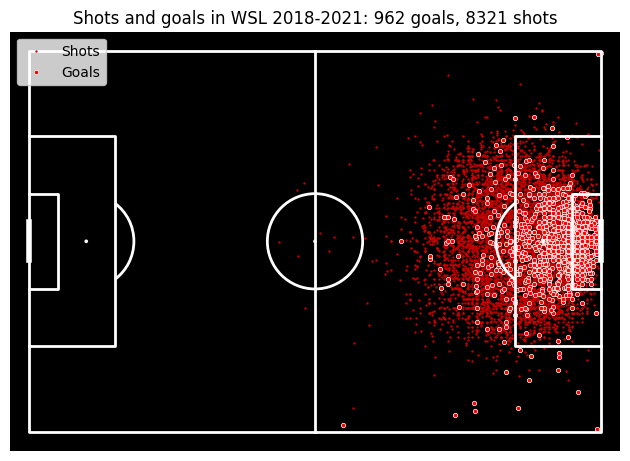

In [57]:
pitch = Pitch(pitch_color="#000000", line_color="#ffffff", line_zorder=2)
fig, ax = pitch.draw(nrows=1, ncols=1)

shots_scatter = ax.scatter(
    [location[0] for location in all_shots["location"].values],
    [location[1] for location in all_shots["location"].values],
    c="#cc0000",
    s=0.5,
    label="Shots",
)
shots_scatter = ax.scatter(
    [location[0] for location in all_goals["location"].values],
    [location[1] for location in all_goals["location"].values],
    c="r",
    edgecolors="w",
    lw=0.5,
    s=10,
    label="Goals",
)
ax.legend()
ax.set_title(
    f"Shots and goals in WSL 2018-2021: {len(all_goals)} goals, {len(all_shots)} shots"
)

In [71]:
binned_shots_count = pitch.bin_statistic(
    x=[location[0] for location in all_shots["location"].values],
    y=[location[1] for location in all_shots["location"].values],
    statistic="count",
    bins=(60, 40),
)
binned_goals_count = pitch.bin_statistic(
    x=[location[0] for location in all_goals["location"].values],
    y=[location[1] for location in all_goals["location"].values],
    statistic="count",
    bins=(60, 40),
)

Text(0.5, 1.0, 'Goals in WSL 2018-2021')

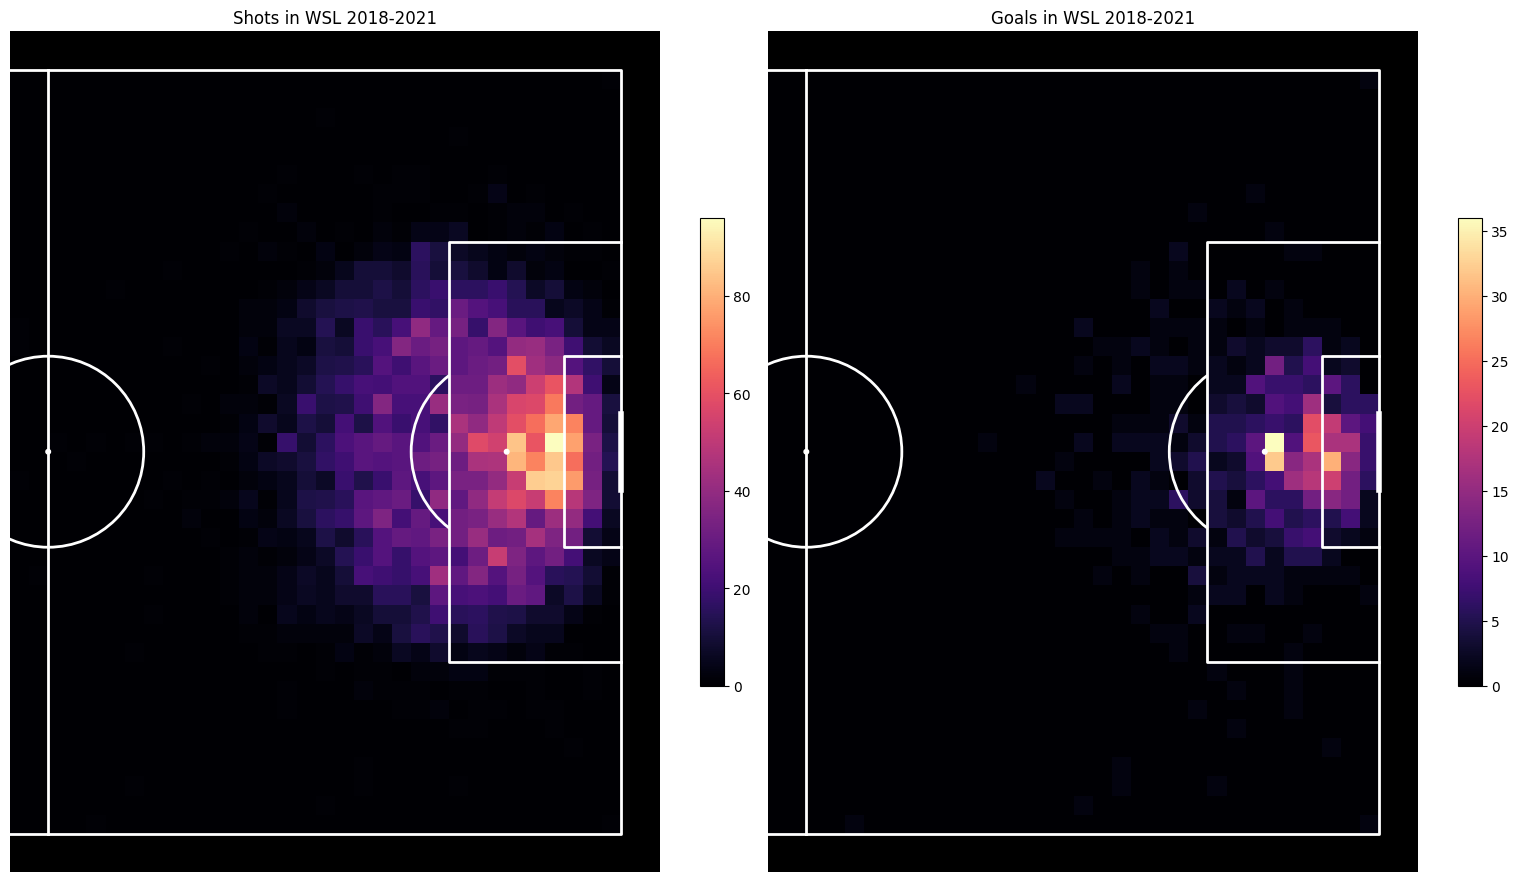

In [72]:
heatmap_pitch = Pitch(
    half=True, pitch_color="#000000", line_color="#ffffff", line_zorder=2
)
fig, axs = heatmap_pitch.draw(nrows=1, ncols=2, figsize=(16, 12))
shots_heatmap = pitch.heatmap(binned_shots_count, ax=axs[0], cmap="magma")
fig.colorbar(shots_heatmap, ax=axs[0], shrink=0.4)
axs[0].set_title("Shots in WSL 2018-2021")

shots_heatmap = pitch.heatmap(binned_goals_count, ax=axs[1], cmap="magma")
fig.colorbar(shots_heatmap, ax=axs[1], shrink=0.4)
axs[1].set_title("Goals in WSL 2018-2021")

(0.0, 80.0)

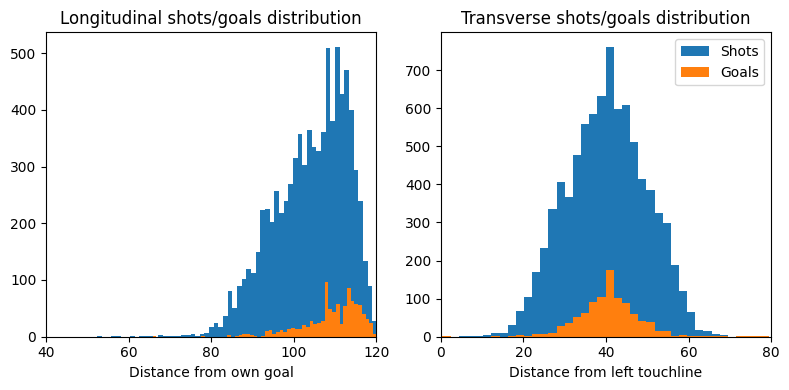

In [77]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))

axs[0].hist([location[0] for location in all_shots["location"].values], bins=60)
axs[0].hist([location[0] for location in all_goals["location"].values], bins=60)
axs[0].set_title("Longitudinal shots/goals distribution")
axs[0].set_xlim(40, 120)
axs[0].set_xlabel("Distance from own goal")

axs[1].hist([location[1] for location in all_shots["location"].values], bins=40)
axs[1].hist([location[1] for location in all_goals["location"].values], bins=40)
axs[1].set_title("Transverse shots/goals distribution")
axs[1].legend(["Shots", "Goals"])
axs[1].set_xlabel("Distance from left touchline")
axs[1].set_xlim(0, 80)

Creating the train/test dataset for location

In [122]:
location_xg_dataset = all_shots[["location", "shot_outcome"]]
location_xg_dataset.loc[location_xg_dataset["shot_outcome"] == "Goal", "label"] = 1
location_xg_dataset.loc[location_xg_dataset["label"].isna(), "label"] = 0
location_xg_dataset = location_xg_dataset.drop(columns=["shot_outcome"])

location_xg_dataset["x_pos"] = location_xg_dataset["location"].apply(lambda x: x[0])
location_xg_dataset["y_pos"] = location_xg_dataset["location"].apply(lambda x: x[1])
location_xg_dataset = location_xg_dataset.drop(columns=["location"])
location_xg_dataset.head()

,label,x_pos,y_pos
418201,0.0,100.6,54.6
418202,0.0,109.4,43.0
418203,0.0,95.6,38.9
418204,0.0,95.6,44.6
418205,0.0,111.0,33.7


<BarContainer object of 2 artists>

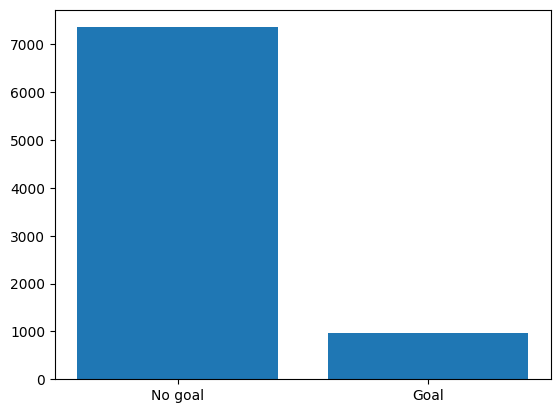

In [123]:
plt.bar(
    ["No goal", "Goal"],
    [
        len(search_in_dataframe(location_xg_dataset, label=0)),
        len(search_in_dataframe(location_xg_dataset, label=1)),
    ],
)

Text(0.5, 1.0, 'Labels against y position')

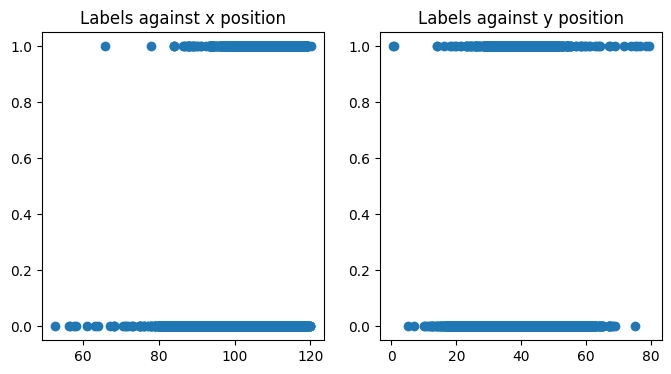

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(location_xg_dataset["x_pos"], location_xg_dataset["label"])
axs[0].set_title("Labels against x position")

axs[1].scatter(location_xg_dataset["y_pos"], location_xg_dataset["label"])
axs[1].set_title("Labels against y position")

We propose that we can use polar coordinates to the opposition goal to better quantify location.

In [125]:
import math

goal_location = (120, 40)


def get_angle_to_goal(x, y):
    return math.degrees(
        math.atan(abs(y - goal_location[1]) / abs(x - goal_location[0]))
    )


def get_distance_to_goal(x, y):
    return math.sqrt(
        (abs(x - goal_location[0])) ** 2 + (abs(y - goal_location[1])) ** 2
    )


location_xg_dataset["angle"] = location_xg_dataset.apply(
    lambda df: get_angle_to_goal(df["x_pos"], df["y_pos"]), axis=1
)
location_xg_dataset["distance"] = location_xg_dataset.apply(
    lambda df: get_distance_to_goal(df["x_pos"], df["y_pos"]), axis=1
)
location_xg_dataset = location_xg_dataset.drop(columns=["x_pos", "y_pos"])
location_xg_dataset

,label,angle,distance
418201,0.0,36.964289,24.280033
418202,0.0,15.802514,11.016351
418203,0.0,2.581259,24.424782
418204,0.0,10.676356,24.829821
418205,0.0,34.992020,10.985900
...,...,...,...
352554,0.0,35.537678,8.602325
352555,0.0,38.290163,24.207437
352556,0.0,27.474432,28.178006
352557,1.0,14.036243,4.123106


In [137]:
location_xg_dataset.iterrows()

<generator object DataFrame.iterrows at 0x187402040>

(array([ 6., 11., 11., 18., 38., 39., 39., 51., 48., 50., 36., 38., 41.,
        36., 47., 65., 39., 34., 26., 32., 19., 19., 12., 24., 15., 11.,
         8., 10., 14., 10., 17., 10.,  6.,  8., 11.,  7.,  4.,  8.,  1.,
         5.,  5.,  3.,  5.,  5.,  4.,  3.,  1.,  0.,  2.,  1.,  0.,  0.,
         3.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.        ,  1.72822459,  2.45644919,  3.18467378,  3.91289837,
         4.64112297,  5.36934756,  6.09757215,  6.82579675,  7.55402134,
         8.28224593,  9.01047053,  9.73869512, 10.46691971, 11.19514431,
        11.9233689 , 12.65159349, 13.37981809, 14.10804268, 14.83626727,
        15.56449187, 16.29271646, 17.02094105, 17.74916565, 18.47739024,
        19.20561483, 19.93383943, 20.66206402, 21.39028861, 22.11851321,
        22.8467378 , 23.5749624 , 24.30318699, 25.0314

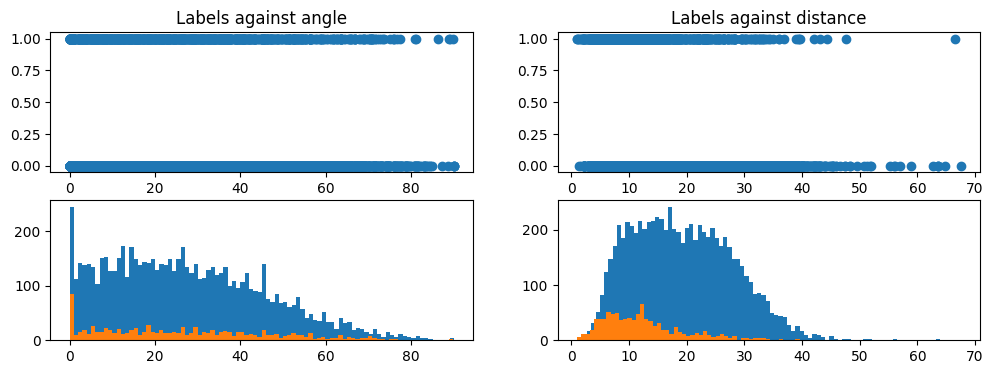

In [142]:
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
axs[0, 0].scatter(location_xg_dataset["angle"], location_xg_dataset["label"])
axs[0, 0].set_title("Labels against angle")

axs[0, 1].scatter(location_xg_dataset["distance"], location_xg_dataset["label"])
axs[0, 1].set_title("Labels against distance")

axs[1, 0].hist(
    [row["angle"] for _, row in location_xg_dataset.iterrows() if row["label"] == 0],
    bins=90,
)
axs[1, 0].hist(
    [row["angle"] for _, row in location_xg_dataset.iterrows() if row["label"] == 1],
    bins=90,
)

axs[1, 1].hist(
    [row["distance"] for _, row in location_xg_dataset.iterrows() if row["label"] == 0],
    bins=90,
)
axs[1, 1].hist(
    [row["distance"] for _, row in location_xg_dataset.iterrows() if row["label"] == 1],
    bins=90,
)

We can try automatically fitting a logistic regression model using scikit-learn:

In [126]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    location_xg_dataset[["angle", "distance"]],
    location_xg_dataset["label"],
    test_size=0.25,
    random_state=16,
)

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

model = LogisticRegression(random_state=16)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

c_matrix = confusion_matrix(y_test, y_pred)
c_matrix

array([[1850,    0],
       [ 231,    0]])

The model was pretty rubbish and failed to predict any goals. 

There are a couple of issues here:
- There is a big spike for angle = 0, which we propose to be because of all the penalties. We propose that removing this will improve the results.
- We propose that visualising the probability of scoring for each bin might give a better idea of how to build a model manually.

Removing all penalties

In [144]:
all_shots["shot_type"].unique()

array(['Open Play', 'Free Kick', 'Penalty', 'Corner'], dtype=object)

In [149]:
location_xg_dataset_open_play = search_in_dataframe(all_shots, shot_type="Open Play")[
    ["location", "shot_outcome"]
]
location_xg_dataset_open_play.loc[
    location_xg_dataset_open_play["shot_outcome"] == "Goal", "label"
] = 1
location_xg_dataset_open_play.loc[
    location_xg_dataset_open_play["label"].isna(), "label"
] = 0
location_xg_dataset_open_play = location_xg_dataset_open_play.drop(
    columns=["shot_outcome"]
)

location_xg_dataset_open_play["x_pos"] = location_xg_dataset_open_play[
    "location"
].apply(lambda x: x[0])
location_xg_dataset_open_play["y_pos"] = location_xg_dataset_open_play[
    "location"
].apply(lambda x: x[1])
location_xg_dataset_open_play = location_xg_dataset_open_play.drop(columns=["location"])

location_xg_dataset_open_play["angle"] = location_xg_dataset_open_play.apply(
    lambda df: get_angle_to_goal(df["x_pos"], df["y_pos"]), axis=1
)
location_xg_dataset_open_play["distance"] = location_xg_dataset_open_play.apply(
    lambda df: get_distance_to_goal(df["x_pos"], df["y_pos"]), axis=1
)
location_xg_dataset_open_play = location_xg_dataset_open_play.drop(
    columns=["x_pos", "y_pos"]
)

location_xg_dataset_open_play

,label,angle,distance
418201,0.0,36.964289,24.280033
418202,0.0,15.802514,11.016351
418203,0.0,2.581259,24.424782
418204,0.0,10.676356,24.829821
418205,0.0,34.992020,10.985900
...,...,...,...
352554,0.0,35.537678,8.602325
352555,0.0,38.290163,24.207437
352556,0.0,27.474432,28.178006
352557,1.0,14.036243,4.123106


(array([ 4.,  6.,  8.,  6., 13., 18., 29., 30., 29., 24., 37., 39., 36.,
        32., 23., 31., 25., 29., 22., 20., 22., 19., 27., 29., 27., 21.,
        19., 19., 11., 18., 12.,  9., 15., 14.,  9.,  4.,  9.,  6.,  5.,
         8., 13.,  4., 11., 10.,  6.,  2.,  3.,  6.,  6.,  4.,  5.,  3.,
         5.,  0.,  3.,  2.,  4.,  2.,  3.,  3.,  2.,  3.,  2.,  1.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.        ,  1.51882483,  2.03764965,  2.55647448,  3.07529931,
         3.59412414,  4.11294896,  4.63177379,  5.15059862,  5.66942345,
         6.18824827,  6.7070731 ,  7.22589793,  7.74472275,  8.26354758,
         8.78237241,  9.30119724,  9.82002206, 10.33884689, 10.85767172,
        11.37649654, 11.89532137, 12.4141462 , 12.93297103, 13.45179585,
        13.97062068, 14.48944551, 15.00827034, 15.52709516, 16.04591999,
        16.56474482, 17.08356964, 17.60239447, 18.1212

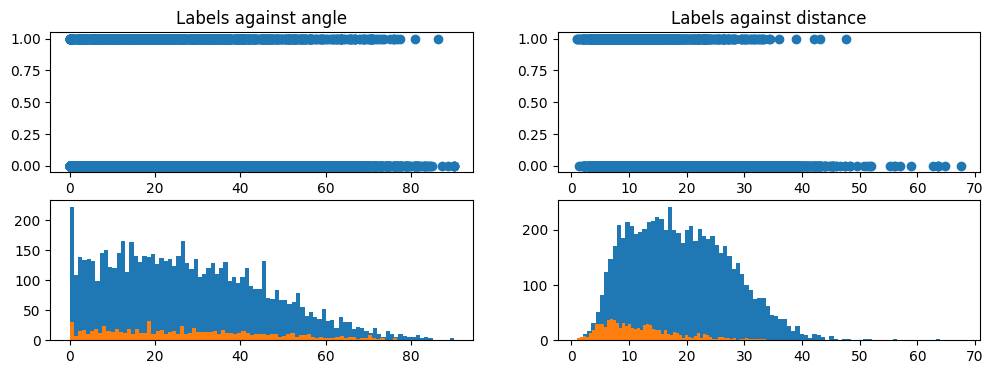

In [150]:
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
axs[0, 0].scatter(
    location_xg_dataset_open_play["angle"], location_xg_dataset_open_play["label"]
)
axs[0, 0].set_title("Labels against angle")

axs[0, 1].scatter(
    location_xg_dataset_open_play["distance"], location_xg_dataset_open_play["label"]
)
axs[0, 1].set_title("Labels against distance")

axs[1, 0].hist(
    [
        row["angle"]
        for _, row in location_xg_dataset_open_play.iterrows()
        if row["label"] == 0
    ],
    bins=90,
)
axs[1, 0].hist(
    [
        row["angle"]
        for _, row in location_xg_dataset_open_play.iterrows()
        if row["label"] == 1
    ],
    bins=90,
)

axs[1, 1].hist(
    [
        row["distance"]
        for _, row in location_xg_dataset_open_play.iterrows()
        if row["label"] == 0
    ],
    bins=90,
)
axs[1, 1].hist(
    [
        row["distance"]
        for _, row in location_xg_dataset_open_play.iterrows()
        if row["label"] == 1
    ],
    bins=90,
)